# <span style="font-variant:small-caps;">Reveal2Revise</span> 

In real-world AI applications, deep neural networks are prone to pick up spurious correlations in the training data and develop shortcut behavior. This means that models start relying on features or data artifacts that are irrelevant to the actual task, yet correlating with the target label. In particular for high-stakes applications, such as medical tasks like Melanoma detection, this can have fatal consequences, as the data artifacts do not generalize and may lead to mispredictions when deploying the model in real-world under distribution shifts, when the shortcut is not applicable. 

<div align="center">
    <img src="../static/r2r_overview_new.png" style="max-width: 800px; width: 100%;">
    <p style="text-align: center;">Reveal2Revise Overview</p>
</div>


In this notebook, we will follow the Reveal2Revise framework to validate and correct the behavior of a ResNet50 model trained on ISIC2019 for Melanoma detection from dermascopic images. 
Specifically, we will: 

1. [**Compute local explanations**](#1_local_xai) for selected test samples and visualize them via heatmaps.
2. [**Compute glocal (=local+global) explanations**](#2_glocal_xai) for selected test samples.
3. <img src="../static/icons/step1.png" style="height: 16px;"/> [**Model Validation**](#3_model_validation): Analyze explanations both from the data and the model perspective to identify spurious correlations.
   - <img src="../static/icons/step1a.png" style="height: 16px;"/> [**Data perspective**](#3a_data_perspective): Are there outlier *samples*, causing the model to behave differently?
   - <img src="../static/icons/step1b.png" style="height: 16px;"/> [**Model perspective**](#3b_model_perspective): Are there outlier model representations (i.e., neurons/concepts) behaving different from others?
   - <img src="../static/icons/step1a.png" style="height: 16px;"/>/<img src="../static/icons/step1b.png" style="height: 16px;"/>[**Compute Prototypical Concept-Based eXplanations (PCX)**](#3c_pcx) to analyze stereotypical prediction behavior.
4. <img src="../static/icons/step3.png" style="height: 16px;"/> [**Correct**](#4_model_correction) the model's prediction behavior wrt an identified spurious correlation.
5. <img src="../static/icons/step4.png" style="height: 16px;"/> [**Re-evaluate**](#5_evaluation) the model.

## Prerequisites

**Download Data** (from https://challenge.isic-archive.com/data/#2019):

Assuming that the data is to be stored in ```$DATA_DIR```, run:

```bash
cd $DATA_DIR
wget https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Input.zip
unzip https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Input.zip
wget https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_GroundTruth.csv
```

**Download Pre-trained Model Checkpoint**:

Assuming that the model checkpoint is to be stored in ```$MODEL_DIR```, run:

```bash
cd $MODEL_DIR
wget https://drive.google.com/file/d/14gDopVbcrcZ4P6srcs80AJwsXMl0rslE/view?usp=sharing
```

**TODO**: Install required packages

In [1]:
import sys
sys.path.append('../')

import h5py
import json
import os
import numpy as np
import pandas as pd
import torch
import torchvision
from tqdm import tqdm
from torch.utils.data import DataLoader

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

# Import functions for data/model handling
from datasets import load_dataset
from models import get_fn_model_loader, get_canonizer

# Import some additional helper functions
from notebooks.utils.preprocessing import precompute_activations_and_relevances
from notebooks.utils.dataset import AttackedDataset
from notebooks.utils.helpers import cosinesim_matrix, get_2d_data
from notebooks.utils.render import vis_opaque_img_border
from notebooks.utils.run_pcx import run_pcx
from notebooks.utils.plot import (plot_data, 
                                  plot_local_explanations, 
                                  plot_glocal_explanation,
                                  plot_2d_data_embedding,
                                  plot_2d_concept_embedding, 
                                  plot_pcx_matrix,
                                  plot_local_explanations_corrected)


# Import interactive Apps
from notebooks.utils.interactive_apps import (create_dash_app_data_perspective, 
                                              create_dash_app_model_perspective)

/home/pahde/anaconda3/envs/pytorch2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Config
Below, you can configure the required parameters for the Reveal2Revise framework. Make sure to update the paths accordingly. Specifically, make sure to update the following values:

- `ckpt_path`: Path to the downloaded model checkpoint in `$MODEL_DIR`.
- `data_path`: Path to the directory containing the ISIC2019 dataset in `$DATA_DIR`.
- `dir_precomputed_data`: Directory where processed representations (e.g., latent activations/relevances) will be stored. Make sure to have write-permissions to that directory.

In [2]:
config = {
    "config_name": "example_script",
    "artifacts_file": "data/artifacts_isic.json",
    "dataset_name": "isic",
    "data_path": "/media/pahde/Data/ISIC2019",
#     "model_name": "resnet50d",
    "model_name": "vgg16",
#     "layer_name": "identity_2",
    "layer_name": "features.29",
#     "ckpt_path": "/media/pahde/Data/r2r-extended/models/isic_v1/resnet50d_adam_lr0.0005_last.pth",
    "ckpt_path": "/media/pahde/Data/r2r-extended/models/isic_v1/vgg16_sgd_lr0.005_last.pth",
#     "ckpt_path": "/media/pahde/Data/tmp/models/checkpoint_vgg16_isic_last.pth",
    "batch_size": 12,
    "dir_precomputed_data": "/media/pahde/Data/tmp1"
}

In [3]:
# import json
# with open('test_config.json', 'w') as f:
#     json.dump(config, f)

## Load Model and Data

Loading the configured model and dataset. 
The dataset consists of 25,331 dermoscopic images of skin lesions to be classified into 9 benign or malginant categories: Melanoma (MEL), Melanocytic nevus (NV), Basal cell carcinoma (BCC), Actinic keratosis (AK), Benign keratosis (BKL), Dermatofibroma (DF), Vascular lesion (VASC), Squamous cell carcinoma (SCC), None of the others (UNK). The majority of samples (12875/25331 $\approx$ 50.8%) are of class NV, which is a benign skin condition.

When plotting a few samples, no obvious data-related problems are apparent at first glance. 

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = load_dataset(config, normalize_data=True)
dataset_test = dataset.get_subset_by_idxs(dataset.idxs_test)

model = get_fn_model_loader(model_name=config['model_name'])(n_class=len(dataset.classes),
                                                             ckpt_path=config['ckpt_path'], 
                                                             device=device).to(device).eval()


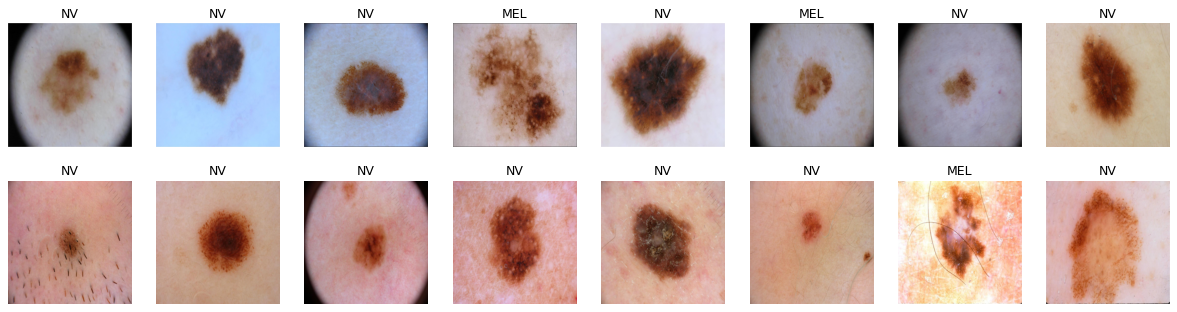

In [5]:
plot_data(dataset_test, dpi=75)

<a id='1_local_xai'></a>
# 1) Compute Local Explanation for Prediction

We use Layer-wise Relevance Propagation (LRP) to compute local explanations for single predictions. Specifically, we use the [EpsilonPlusFlat composite](https://zennit.readthedocs.io/en/latest/reference/zennit.composites.html#zennit.composites.EpsilonPlusFlat) and [model canonization](https://zennit.readthedocs.io/en/latest/reference/zennit.canonizers.html).
We utilize the implementation in [**zennit-crp**](https://github.com/rachtibat/zennit-crp), which is built upon [**zennit**](https://github.com/chr5tphr/zennit). Check out the zennit [documentation](https://zennit.readthedocs.io/en/latest/) for further details. 

We plot local explanation heatmaps for a few selected samples. While most heatmaps look reasonable, the explanation for the last prediction reveals that the model seems to be distracted by an data artifact: a colorful band-aid. In this case, even though the prediction of the model is correct (NV), it cannot be trusted, as the model does not rely on medically relevant features. 

### Configure Explainer

In [6]:
# Import CRP/zennit-crp
from crp.attribution import CondAttribution
from crp.concepts import ChannelConcept
from crp.visualization import FeatureVisualization
from zennit.composites import EpsilonPlusFlat

attribution = CondAttribution(model)

canonizers = get_canonizer(config['model_name'])
composite = EpsilonPlusFlat(canonizers=canonizers)

In [7]:
sorted(dataset_test.sample_ids_by_artifact["band_aid"])[:6]

[52, 53, 54, 55, 56, 57]

In [8]:
SAMPLE_IDS = [2, 3, 12, 14, 53]

data = torch.stack([dataset_test[j][0] for j in SAMPLE_IDS], dim=0)
target = torch.stack([dataset_test[j][1] for j in SAMPLE_IDS], dim=0)

# Explain prediction wrt TRUE label
condition = [{"y": c_id.item()} for c_id in target]
attr = attribution(data.to(device).requires_grad_(), condition, composite)

/home/pahde/anaconda3/envs/pytorch2/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


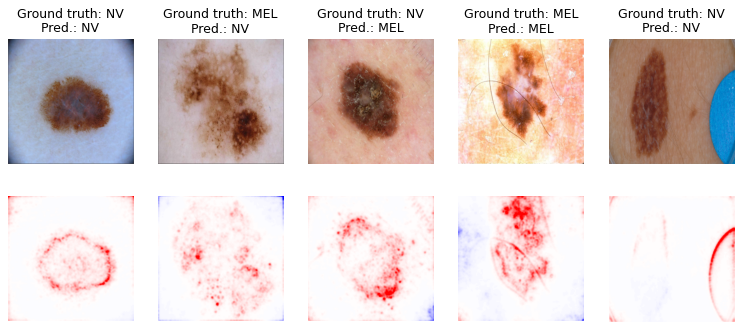

In [9]:
samples = [dataset.reverse_normalization(x).numpy() for x in data]
preds = attr.prediction.argmax(1)
hms = attr.heatmap.detach().cpu().numpy()
hms /= np.abs(hms).max(axis=(1,2), keepdims=True)

plot_local_explanations(samples, target, preds, hms, dataset.classes, dpi=75, level=1)

<a id='2_glocal_xai'></a>

# 2) Glocal Explanations
## Connecting *local* explanations with *global* model insights

Next, we use Concept Relevance Propagation (CRP) to connect local explanations for single predictions with global model insights. Specifically, given an input sample, we compute:
1. The local explanation with respect to the predicted class using LRP.
2. The most *relevant* channels (i.e., convolutional filters) of a selected layer (here: the last convolutional layer, configured above as `layer_name`)
3. Feature visualizations using RelMax for these channels. RelMax selects images from a reference dataset (e.g., the training set, but others are possible too) that achieve the highest relevance scores for the neuron (i.e., concept) of interest.
4. Concept-specific (or channel-specific) heatmaps for the given input image.

It can be seen that the model relies on concepts mostly focusing on the band-aid artifact. Specifically **TODO**

In [10]:
## CRP configuration

layer_name = config['layer_name']
MAX_MODE = "relevance"
N_CONCEPTS = 5
N_REFIMGS = 6

dataset_ref = load_dataset(config, normalize_data=False)
dataset_ref = dataset_ref.get_subset_by_idxs(dataset_ref.idxs_train)

fv_name = f"{config['dir_precomputed_data']}/crp_files/{config['dataset_name']}_train_{config['model_name']}"
cc = ChannelConcept()
layer_map = {layer_name: cc}
fv = FeatureVisualization(attribution, dataset_ref, layer_map, preprocess_fn=dataset_ref.normalize_fn, path=fv_name, cache=None)

## CRP Pre-Processing

In order to visualize the concepts, zennit-crp has to run a pre-processing step. Specifically, for each neuron, zennit-crp needs to compute which samples achieve the highest activation or relevance. The pre-processing can be run as described below. However, depending on the model architecture, dataset size, and compute resources, the pre-processing can take a while. Therefore, pre-computed files can be downloaded as follows:

```
**TODO**
```

In [11]:
## (optional) run CRP preprocessing on reference dataset (alternative: download pre-computed files as described above)

if len(os.listdir(f"{fv_name}/ActMax_sum_normed")) == 0:
    fv.run(composite, 0, len(dataset_ref), batch_size=config['batch_size'])
else:
     print(f"CRP files already exist!")

CRP files already exist!


## Visualize glocal explanation

In [12]:
sample_id = 54

In [13]:
# get sample and prediction. 
data_p, y = dataset_test[sample_id]
data_p = data_p.to(device).unsqueeze(0)

pred = model(data_p).detach().argmax().cpu()

# heatmaps will be computed wrt the prediction (alternative: explain wrt ground truth label)
target = pred

# backward pass to compute relevance scores for input (heatmap) and neurons in chosen layer (concepts)
attr = attribution(data_p.clone().requires_grad_(),
                   [{"y": target}],
                   composite,
                   record_layer=[layer_name])

# Compute most relevant concepts (i.e., highest absolute relevance)
channel_rels = cc.attribute(attr.relevances[layer_name], abs_norm=True)
topk = torch.topk(channel_rels[0], N_CONCEPTS)
topk_ind = topk.indices.detach().cpu().numpy()
topk_rel = topk.values.detach().cpu().numpy()

# Compute heatmaps wrt most relevant concepts in given layer
conditions = [{
    "y": target,
    layer_name: c_id
} for c_id in topk_ind]

attribution.model.zero_grad()
attr_cond = attribution(data_p.clone().requires_grad_(), conditions, composite)

# Get reference samples for most relevant concepts for feature visualization
ref_imgs = fv.get_max_reference(topk_ind, layer_name, MAX_MODE, (0, N_REFIMGS), composite=composite, 
                                rf=True, plot_fn=vis_opaque_img_border)

In [14]:
sample_img = dataset_test.reverse_normalization(data_p[0]).detach().cpu()

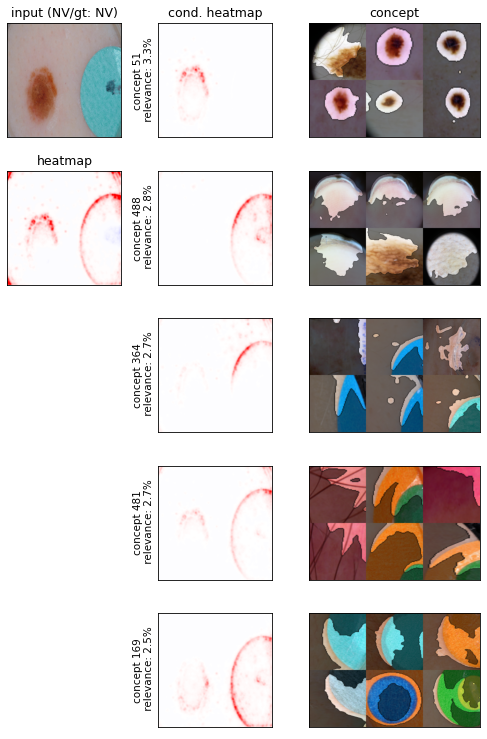

In [15]:
plot_glocal_explanation(sample_img, attr, attr_cond.heatmap, N_CONCEPTS, N_REFIMGS, topk_ind, topk_rel, ref_imgs, target, pred, y, dataset_test.classes, dpi=75)

<a id='3_model_validation'></a>
<div style="display: flex; align-items: center;">
    
    <h2 style="margin: 0;">3) Model Validation (step </h2>
    <img src="../static/icons/step1.png" style="height: 26px; margin-left: -20px;"/>
    <h2 style="margin: 0;">)</h2>
</div>
However, the example provided above is an incidental discovery, made possible only because we provided the sample ID for one of the few affected images. Next, we want to validate model behavior without prior knowledge on problematic samples.

For the identification of model weaknesses, we distuingish between the data perspective and the model perspective. Both operate on input or latent activations or relevance scores, commonly in aggregated manner, for instance by applying max-pooling. Thus, all considered approaches can be run using the same pre-computed data. Whereas the data perspective computes pair-wise similarities between samples, thereby finding odd samples, the model perspective computes pair-wise similarities between neurons to identify outlier neuron/concept representations.

<div align="center">
    <img src="../static/data_vs_concept_perspective.png" style="max-width: 800px; width: 100%;">
    <p style="text-align: center;">Data- vs. model perspective for model validation</p>
</div>

### (optional) Pre-Process Data for Global Analysis

The model validation from both, data and model perspective, requires latent activations or relevances for the entire dataset (see left in figure above). These scores are obtained in a pre-processing step. The pre-processing can be run by uncommenting the code in the following cell. Alternatively, we provide pre-computed files that can be downloaded as follows:

```
**TODO**
```

In [16]:
## (optional) pre-compute relevances and activations for all samples (alternative: download pre-computed files as described above)

path_precomputed = f"{config['dir_precomputed_data']}/global_relevances_and_activations/{config['dataset_name']}/{config['model_name']}"

if os.path.isdir(path_precomputed) and len(os.listdir(path_precomputed)) != 0:
    print(f"Latent activations/relevances already computed! ('{path_precomputed}')")
else:
    split = "all"
    precompute_activations_and_relevances(model, dataset, attribution, composite, split, config)

Latent activations/relevances already computed! ('/media/pahde/Data/tmp1/global_relevances_and_activations/isic/vgg16')


In [17]:
# The analysis is run with respect to a chosen class label, which can be configured below.

print(f"Available classes are: {dataset.classes}")

CLASS_ID = 1

print(f"Selected class: {dataset.classes[CLASS_ID]}")

Available classes are: ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']
Selected class: NV


<a id='3a_data_perspective'></a>
<div style="display: flex; align-items: center;">
    
    <h2 style="margin: 0;">3a) Data Perspective (</h2>
    <img src="../static/icons/step1a.png" style="height: 26px; margin-left: -22px;"/>
    <h2 style="margin: 0;">)</h2>
</div>

In [18]:
from experiments.preprocessing.run_spray_preprocessing import run_spray

## Run SpRAy preprocessing
# run_spray(config=config, 
#           variant="spectral",  
#           split="all", 
#           class_indices=[0,1], 
#           n_eigval=32, 
#           n_clusters=[1,2],  
#           n_neighbors=32)

In [19]:
emb_type_spray = "tsne"

In [20]:
# Load SpRAy embedding
analysis_file = f"{config['dir_precomputed_data']}/spray/{config['dataset_name']}/{config['config_name']}_all.hdf5"
with h5py.File(analysis_file, 'r') as fp:
    sample_ids = np.array(fp[str(CLASS_ID)]['index'])
    data_2d = fp[str(CLASS_ID)]['embedding'][emb_type_spray][::1]
    
print(data_2d.shape)

(12875, 2)


### Option 1: Basic Data Discovery

In [21]:
samples_2d_pd = pd.DataFrame({
    "x": data_2d[:, 0],
    "y": data_2d[:, 1],
    "id": np.arange(len(data_2d))
})

samples_2d_pd[["x", "y"]] /= np.abs(samples_2d_pd[["x", "y"]].values).max()

In [22]:
dataset_cl = dataset.get_subset_by_idxs(np.where(dataset.metadata[dataset.classes[CLASS_ID]].values == 1)[0])
print(len(dataset_cl))

12875


In [23]:
outlier_samples = [368,519,434,399,430,451,503,416,372,390,540,9841]# [396, 412, 392, 406, 502, 422, 427, 446, 537, 394, 474, 363]
outlier_labels = np.zeros(len(data_2d)).astype(np.uint8)
outlier_labels[outlier_samples] = 1
sizes = [2 if is_outlier else 0.4 for is_outlier in outlier_labels]

In [56]:
# Create a scatter plot
# fig = px.scatter(samples_2d_pd, x="x", y="y", hover_name="id", color=outlier_labels, size=sizes, width=600, height=600)
# fig.update_layout(showlegend=False)
# fig.show()

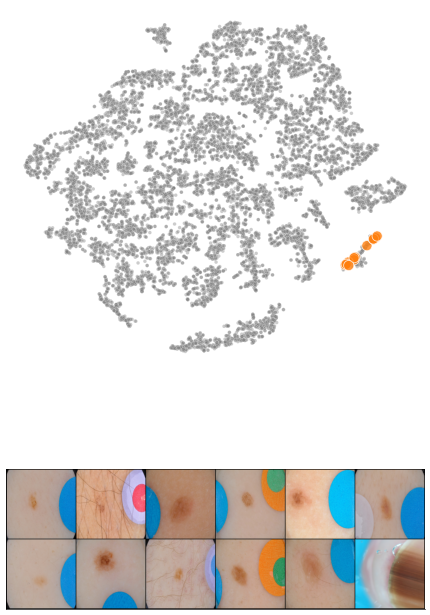

In [25]:
outlier_imgs = [dataset.reverse_normalization(dataset_cl[i][0]) for i in outlier_samples]

plot_2d_data_embedding(data_2d, outlier_labels, outlier_imgs, dpi=60)

### Option 2: Interactive Data Discovery

In [26]:
# Run the app inline
# app = create_dash_app_data_perspective(samples_2d_pd, dataset_cl, percentage_images=0.025)
# app.run_server(debug=True, port=8050)

<a id='3b_model_perspective'></a>

<div style="display: flex; align-items: center;">
    
    <h2 style="margin: 0;">3b) Model Perspective (</h2>
    <img src="../static/icons/step1b.png" style="height: 26px; margin-left: -22px;"/>
    <h2 style="margin: 0;">)</h2>
</div>

In [27]:
# pick between 'umap' and 'tsne'
algorithm = "umap"

In [28]:
# Load pre-computed activations/relevances

with h5py.File(f"{path_precomputed}/class_{CLASS_ID}_all.hdf5", 'r') as file:
    layer_data = file[config['layer_name']]
    data_latent = torch.tensor(np.array(layer_data["rels_max"]))
    
print(f"Loaded precomputed relevances wrt class '{CLASS_ID}' for layer {config['layer_name']} of shape {data_latent.shape}")

Loaded precomputed relevances wrt class '1' for layer features.29 of shape torch.Size([12875, 512])


In [29]:
# Compute pair-wise cosine similarities
similarities = cosinesim_matrix(data_latent.transpose(0,1))
print(similarities.shape)

# Embed in 2D
D = (1-similarities).clamp(min=0)
data_2d = get_2d_data(D, algorithm=algorithm, metric="precomputed")
print(f"New shape: {data_2d.shape}")

torch.Size([512, 512])
New shape: (512, 2)


### Concept Discovery (Basic)

In [30]:
concept_2d_pd = pd.DataFrame({
    "x": data_2d[:, 0],
    "y": data_2d[:, 1],
    "id": np.arange(len(data_2d))
})

concept_2d_pd[["x", "y"]] /= np.abs(concept_2d_pd[["x", "y"]].values).max()

In [31]:
outlier_concepts = [169,481] # [481,308] # [480,757,829]
outlier_labels = np.zeros(len(data_2d)).astype(np.uint8)
outlier_labels[outlier_concepts] = 1
sizes = [2 if is_outlier else 0.4 for is_outlier in outlier_labels]

In [55]:
# Create a scatter plot
# fig = px.scatter(concept_2d_pd, x="x", y="y", hover_name="id", color=outlier_labels, size=sizes, size_max=10, width=600, height=600)
# fig.update_layout(showlegend=False)
# fig.show()

In [33]:
# Define outlier concepts and retrieve reference samples
ref_imgs_outlier_concepts = fv.get_max_reference(outlier_concepts, layer_name, "relevance", (0, 5), composite=composite, rf=True,
                                                 plot_fn=vis_opaque_img_border)

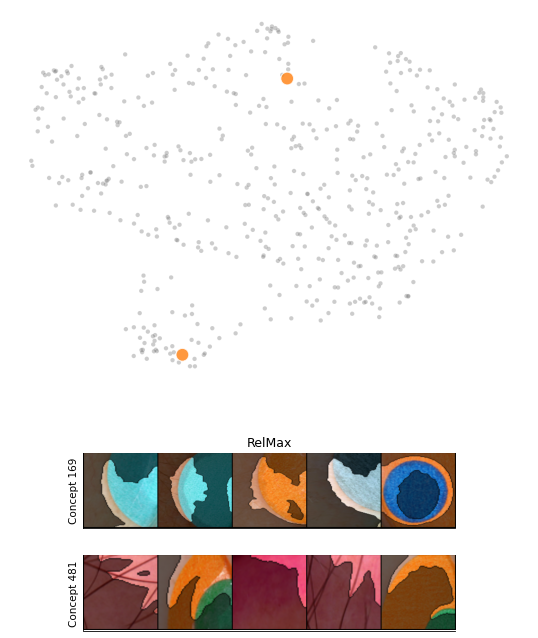

In [34]:
plot_2d_concept_embedding(data_2d, outlier_concepts, ref_imgs_outlier_concepts, dpi=75)

In [35]:
## precompute all concept visualuzations
ref_imgs_all_concepts = {cid: fv.get_max_reference(cid, layer_name, "relevance", (0, 16), composite=composite, rf=True,
                                                 plot_fn=vis_opaque_img_border)[cid] for cid in tqdm(range(len(concept_2d_pd)))}

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [05:20<00:00,  1.60it/s]


In [36]:
# app = create_dash_app_model_perspective(concept_2d_pd, ref_imgs_all_concepts, percentage_images=0.1)
# app.run_server(mode='inline', debug=True, port=8050)

<a id='3c_pcx'></a>

<div style="display: flex; align-items: center;">
    
    <h2 style="margin: 0;">3c) PCX: Combining both perspectives (</h2>
    <img src="../static/icons/step1a.png" style="height: 26px; margin-left: -22px;"/>
    <h2 style="margin: 0;">/</h2>
    <img src="../static/icons/step1b.png" style="height: 26px; margin-left: -22px;"/>
    <h2 style="margin: 0;">)</h2>
</div>

In [37]:
## PCX configuration
class_id = 1
split = "all"
n_prototypes = 4
top_k_sample_prototype = 4
n_per_prototype = 2
num_ref_concept = 4

In [38]:
# Load pre-computed relevances
features_samples = torch.tensor(np.array(
    h5py.File(f"{path_precomputed}/class_{class_id}_{split}.hdf5")[config['layer_name']]["rel"]
))

# Load pre-computed outputs, ground truth classes, and sample_ids
metadata = torch.load(f"{path_precomputed}/class_{class_id}_{split}_meta.pth")
sample_ids = np.array(metadata["samples"])
outputs = metadata["output"]
classes = np.array([dataset.get_target(i) for i in sample_ids])

In [39]:
outputs

tensor([[12.8796, 14.2212, -2.2737,  ..., -2.7228, -6.5146, -7.8069],
        [12.7919, 15.9953, -2.1476,  ..., -2.4748, -4.2534, -8.5457],
        [14.8560, 15.4782, -5.2856,  ..., -3.1161, -5.8664, -7.4696],
        ...,
        [ 9.2177, 15.5323, -1.5213,  ...,  0.7904, -7.9290, -8.7731],
        [13.2359, 15.7508, -1.9885,  ..., -2.2101, -6.7358, -9.5118],
        [ 6.2641, 14.4121, -1.3209,  ...,  2.3697, -8.5418, -8.4763]])

In [40]:
concept_matrix, prototype_samples, counts, counts_perc, topk_ind = run_pcx(features_samples,
                                                                           outputs,
                                                                           classes,
                                                                           sample_ids,
                                                                           class_id,
                                                                           n_prototypes,
                                                                           top_k_sample_prototype,
                                                                           n_per_prototype)

Initialization 0
  Iteration 10	 time lapse 10.18838s	 ll change 0.04707
Initialization converged: False	 time lapse 10.18849s	 ll 2534.95559


/home/pahde/anaconda3/envs/pytorch2/lib/python3.10/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning:

Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



/home/pahde/dev/r2r-extended/notebooks/../notebooks/utils/plot.py:256: UserWarning:

The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/torch/csrc/utils/tensor_numpy.cpp:206.)



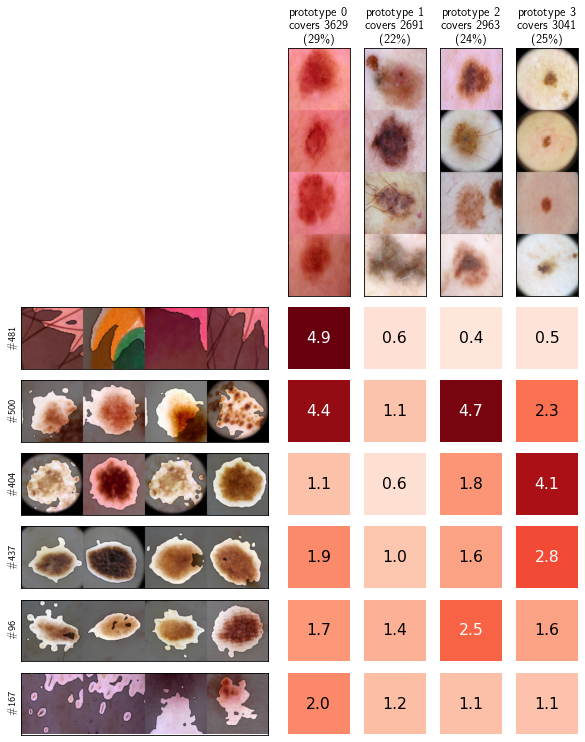

In [41]:
plot_pcx_matrix(concept_matrix, dataset, prototype_samples, ref_imgs_all_concepts, counts, 
                counts_perc, topk_ind, num_ref_concept, top_k_sample_prototype, None, dpi=75)


<a id='4_model_correction'></a>

<div style="display: flex; align-items: center;">
    
    <h2 style="margin: 0;">4) Model Correction (step </h2>
    <img src="../static/icons/step3.png" style="height: 26px; margin-left: -20px;"/>
    <h2 style="margin: 0;">)</h2>
</div>

In [42]:
from experiments.mitigation_experiments.start_model_correction import start_model_correction

config_correction = {
    "artifacts_file": "data/artifacts_isic.json",
    "num_epochs": 1,
    "batch_size": 32,
    "optimizer": "sgd",
    "lr": 0.001,
    "loss": "cross_entropy",
    "artifact": "band_aid",
    "method": "RRClarc",
    "lamb": 10e10,
    "direction_mode": "signal",
    "cav_mode": "cavs_max",
    "cav_scope": [1],
    "criterion": "all_logits_random",
    "checkpoint_dir_corrected": f"data/models_corrected_{config['model_name']}"
}

with open(f"test_config_{config['model_name']}.json", 'w') as f:
    json.dump({**config, **config_correction}, f)
    
# start_model_correction({**config, **config_correction}, num_gpu=1)

In [43]:
config_correction

{'artifacts_file': 'data/artifacts_isic.json',
 'num_epochs': 1,
 'batch_size': 32,
 'optimizer': 'sgd',
 'lr': 0.001,
 'loss': 'cross_entropy',
 'artifact': 'band_aid',
 'method': 'RRClarc',
 'lamb': 100000000000.0,
 'direction_mode': 'signal',
 'cav_mode': 'cavs_max',
 'cav_scope': [1],
 'criterion': 'all_logits_random',
 'checkpoint_dir_corrected': 'data/models_corrected_vgg16'}

<a id='5_evaluation'></a>

<div style="display: flex; align-items: center;">
    
    <h2 style="margin: 0;">5) Model (Re-)evaluation (step </h2>
    <img src="../static/icons/step4.png" style="height: 26px; margin-left: -20px;"/>
    <h2 style="margin: 0;">)</h2>
</div>

In [44]:
## Load corrected model

ckpt_corrected_path = f"{config_correction['checkpoint_dir_corrected']}/{config['config_name']}/last.ckpt"

model_corrected = get_fn_model_loader(model_name=config['model_name'])(n_class=len(dataset.classes),
                                                                       ckpt_path=ckpt_corrected_path, 
                                                                       device=device).to(device).eval()

attribution_corrected = CondAttribution(model_corrected)

2025-09-10 17:47:34,938 - Loading vgg16


### 5a) Evaluate accuracy on clean/attacked data

In [45]:
## Load dataset attacked
config['artifact'] = "band_aid"
config['masks_location'] = "../data"
ds_hm = load_dataset(config, hm=True, normalize_data=True)

ds_attacked = AttackedDataset(ds_hm, "band_aid")

ds_clean_test = ds_hm.get_subset_by_idxs(ds_hm.idxs_test)
ds_attacked_test = ds_attacked.get_subset_by_idxs(ds_hm.idxs_test)

print(len(ds_attacked_test))

2025-09-10 17:47:36,656 - Loading isic_hm


LOADING band_aid
Localized artifacts: 184
Collected 184 artifact samples
2533


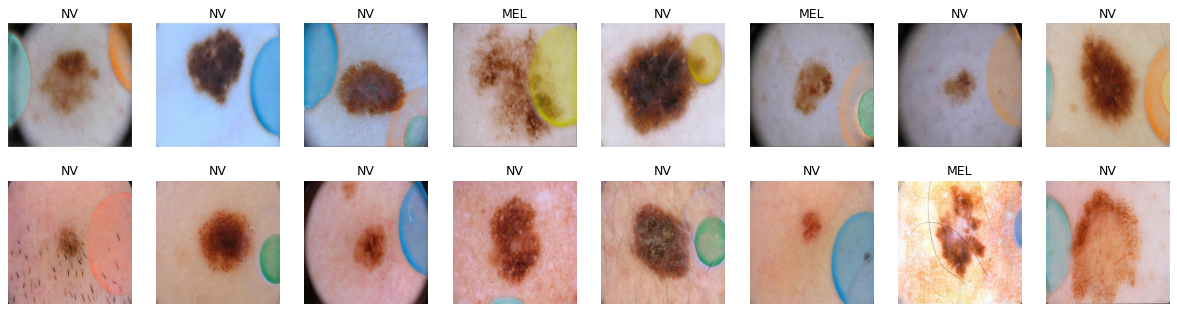

In [46]:
plot_data(ds_attacked_test, dpi=75)

In [47]:
BATCH_SIZE = 16

def evaluate(model, ds, batch_size):
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False)

    preds = []
    ys = []

    for batch in tqdm(dl):
        if len(batch) == 2:
            x, y = batch
        else:
            x, y, m = batch

        preds.append(model(x.to(device)).detach().cpu().argmax(1))
        ys.append(y)
        
    ys = torch.cat(ys)
    preds = torch.cat(preds)
    acc = (ys == preds).numpy().mean()
    return acc

print("Evaluate original model on clean data")
acc_original_clean = evaluate(model, ds_clean_test, BATCH_SIZE)

print("Evaluate corrected model on clean data")
acc_corrected_clean = evaluate(model_corrected, ds_clean_test, BATCH_SIZE)

print("Evaluate original model on attacked data")
acc_original_att = evaluate(model, ds_attacked_test, BATCH_SIZE)

print("Evaluate corrected model on attacked data")
acc_corrected_att = evaluate(model_corrected, ds_attacked_test, BATCH_SIZE)

Evaluate original model on clean data


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159/159 [01:05<00:00,  2.42it/s]


Evaluate corrected model on clean data


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159/159 [01:05<00:00,  2.43it/s]


Evaluate original model on attacked data


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159/159 [01:06<00:00,  2.39it/s]


Evaluate corrected model on attacked data


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159/159 [01:05<00:00,  2.41it/s]


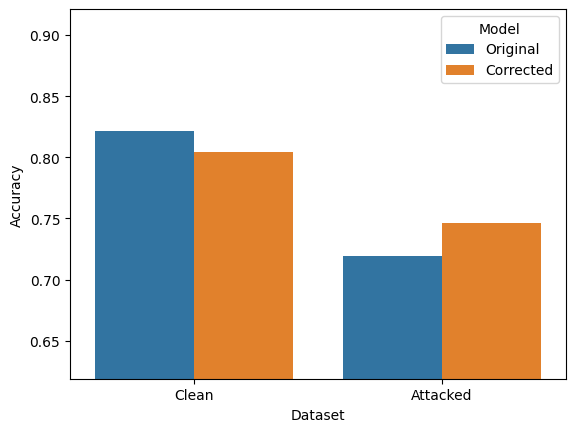

In [48]:
results = pd.DataFrame([
    (acc_original_clean,  "Original", "Clean"),
    (acc_original_att,  "Original", "Attacked"),
    (acc_corrected_clean,  "Corrected", "Clean"),
    (acc_corrected_att,  "Corrected", "Attacked")
], columns=["Accuracy", "Model", "Dataset"])

sns.barplot(results, x="Dataset", y="Accuracy", hue="Model")
plt.ylim(results["Accuracy"].min() - .1, min(results["Accuracy"].max() + .1, 1))
plt.show()

### 5b) Plot Explanation Heatmaps for Attacked Samples

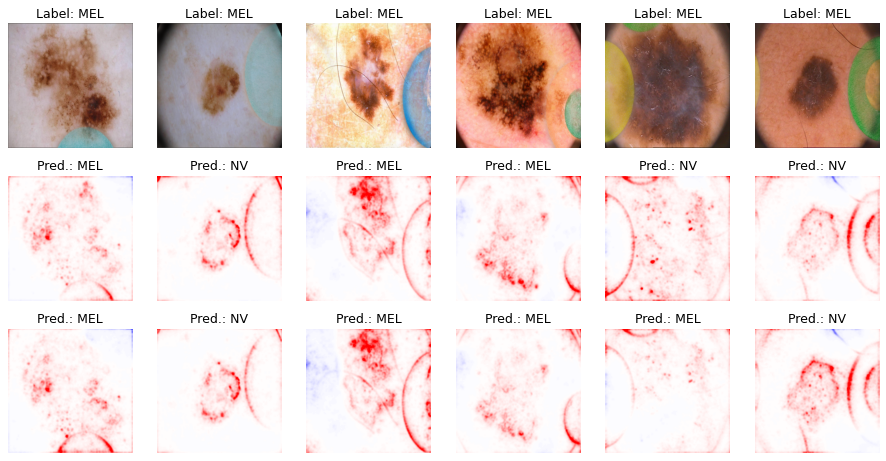

In [49]:
SAMPLE_IDS = [ 3,    5,   14,   30,   31,   32]

data = torch.stack([ds_attacked_test[j][0] for j in SAMPLE_IDS], dim=0)
target = torch.stack([ds_attacked_test[j][1] for j in SAMPLE_IDS], dim=0)

# Compute predictions
preds_original = model(data.to(device)).detach().cpu().argmax(1)
preds_corrected = model_corrected(data.to(device)).detach().cpu().argmax(1)

# Explain prediction wrt PREDICTION
condition_original = [{"y": p.item()} for p in preds_original]
attr_original = attribution(data.clone().to(device).requires_grad_(), condition_original, composite)

condition_corrected = [{"y": p.item()} for p in preds_corrected]
attr_corrected = attribution_corrected(data.clone().to(device).requires_grad_(), condition_corrected, composite)

# Get non-normalized input images
imgs = [ds_attacked_test.reverse_normalization(x).numpy() for x in data]

# Normalize heatmaos
hms_original = attr_original.heatmap.detach().cpu().numpy()
hms_original /= np.abs(hms_original).max(axis=(1,2), keepdims=True)

hms_corrected = attr_corrected.heatmap.detach().cpu().numpy()
hms_corrected /= np.abs(hms_corrected).max(axis=(1,2), keepdims=True)

# Create plots
plot_local_explanations_corrected(imgs, target, preds_original, preds_corrected, hms_original, hms_corrected, ds_attacked_test.classes, dpi=75)

### 5c) Compute artifact relevance

In [50]:
split = "test"
artifact = "band_aid"

idxs_splits = {
    "train": ds_hm.idxs_train,
    "val": ds_hm.idxs_val,
    "test": ds_hm.idxs_test
}

In [51]:
artifact_ids = ds_hm.sample_ids_by_artifact[artifact]
split_ids = idxs_splits[split]

sample_ids = [i for i in split_ids if i in artifact_ids]

ds_hm_split = ds_hm.get_subset_by_idxs(sample_ids)

print(f"Found {len(ds_hm_split)} relevant samples.")

Found 22 relevant samples.


In [52]:
def compute_artifact_relevance(model, ds, batch_size=8):
    gaussian = torchvision.transforms.GaussianBlur(kernel_size=41, sigma=8.0)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False)
    attribution = CondAttribution(model)
    
    scores = []
    for batch in tqdm(dl):
        x, y, mask = batch
        condition = [{"y": t} for t in y]
        attr = attribution(x.to(device).requires_grad_(), condition, composite, init_rel=1)
        
        mask = 1.0 * (mask / mask.abs().flatten(start_dim=1).max(1)[0][:, None, None] > 0.1)
        mask = gaussian(mask.clamp(min=0)) ** 1.0
        mask = 1.0 * (mask / mask.abs().flatten(start_dim=1).max(1)[0][:, None, None] > 0.3)
        mask = mask.to(device)
        
        inside = (attr.heatmap * mask).abs().sum((1, 2)) / (attr.heatmap.abs().sum((1, 2)) + 1e-10)
        scores.extend(inside.cpu().numpy())
        
    return np.array(scores).mean()
#     preds.append(model(x.to(device)).detach().cpu().argmax(1))

In [53]:
art_rel_original = compute_artifact_relevance(model, ds_hm_split)
art_rel_corrected = compute_artifact_relevance(model_corrected, ds_hm_split)
art_rel_corrected
print(f"{art_rel_original:.3f} / {art_rel_corrected:.3f}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.02it/s]

0.573 / 0.479


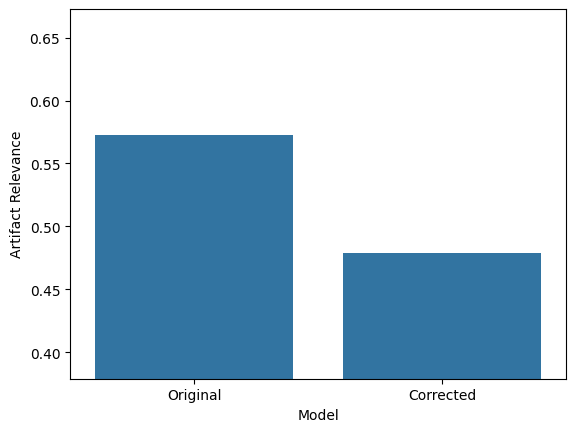

In [54]:
results = pd.DataFrame([
    (art_rel_original,  "Original"),
    (art_rel_corrected,  "Corrected")
], columns=["Artifact Relevance", "Model"])

sns.barplot(results, x="Model", y="Artifact Relevance")
plt.ylim(results["Artifact Relevance"].min() - .1, min(results["Artifact Relevance"].max() + .1, 1))
plt.show()